# Power law example

The power in frequency bins is simulated with a power law.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from jax import jit
import jax.numpy as jnp
import jax.scipy as js
import jax.random as jr

import numpyro
import numpyro.distributions as dist

from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import Normal
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_data

from emcee.autocorr import integrated_time
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth, ChainConfig, PlotConfig

from simulate_data import get_rho

import torch
import zuko

## Load data

The power in each frequency bin is modeled according to the power law,

\begin{equation}
    \vec{\rho}\,(A, \gamma) = A\,\bigg(\frac{\vec{f}}{f_\text{ref}}\bigg)^{-\gamma}\;.
\end{equation}

In [2]:
# load data from dictionary and convert to jax.numpy objects
data_dict = np.load('data.npz')
times = jnp.array(data_dict['times'])
freqs = jnp.array(data_dict['freqs'])
data = jnp.array(data_dict['data'])
signal_inj = jnp.array(data_dict['signal_inj'])
hypers_inj = jnp.array(data_dict['hypers_inj'])
sigma_inj = jnp.float32(data_dict['sigma_inj'])
a_inj = jnp.array(data_dict['a_inj'])
F = jnp.array(data_dict['F'])

# derived objects
rho_inj = get_rho(*hypers_inj)
logrho_inj = jnp.log10(rho_inj[::2])
Na = a_inj.shape[0]
Nf = Na // 2
Nt = times.shape[0]

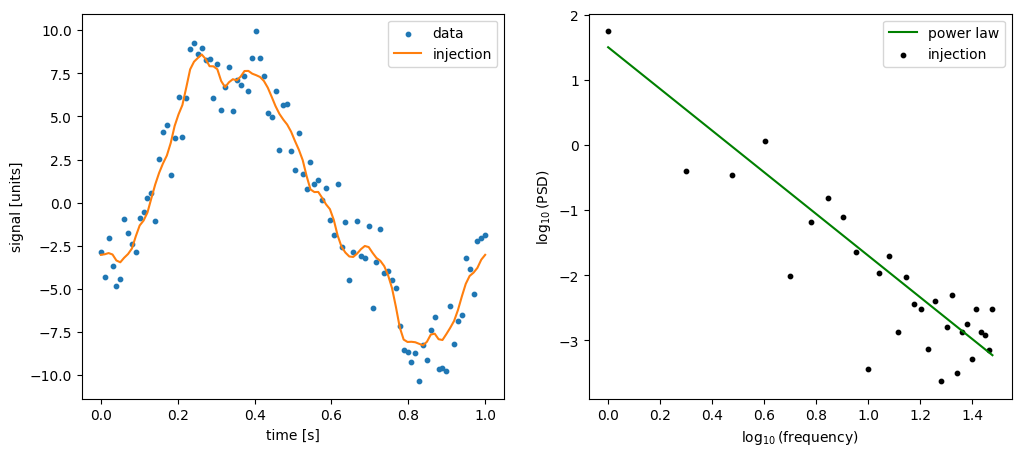

In [3]:
# plot data and injection
# time-domain
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(times, data, color='C0', s=10, label='data')
plt.plot(times, signal_inj, color='C1', label='injection')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend()

# frequency-domain
plt.subplot(1, 2, 2)
plt.plot(jnp.log10(freqs), jnp.log10(2 * rho_inj[::2]), color='green', label='power law')
plt.scatter(jnp.log10(freqs), jnp.log10(a_inj[::2]**2. + a_inj[1::2]**2.), color='k', s=10, label='injection')
plt.xlabel(r'$\log_{10}$(frequency)')
plt.ylabel(r'$\log_{10}$(PSD)')
plt.legend()
plt.show()

## Free spectral model

In [4]:
# parameter bounds
logrho_mins = jnp.array([-10.] * Nf)
logrho_maxs = jnp.array([10.] * Nf)
sigma_min = 0.
sigma_max = 10.
a_min = -100.
a_max = 100.
x_mins = jnp.concatenate((logrho_mins, jnp.array([sigma_min]), jnp.array([a_min] * Na)))
x_maxs = jnp.concatenate((logrho_maxs, jnp.array([sigma_max]), jnp.array([a_max] * Na)))

# parameter labels
logrho_labels = np.array([rf'$\log_{{{10}}} \rho_{{{i}}}$' for i in np.arange(1, Nf + 1)])
sigma_label = r'$\sigma$'
a_labels = np.array([rf'$a_{{{i // 2}}}$' if i % 2 == 0 else rf'$b_{{{i // 2}}}$'
                     for i in np.arange(2, 2 + Na)])
x_labels = np.concatenate((logrho_labels, np.array([sigma_label]), a_labels))

# injected parameters
x_inj = jnp.concatenate((logrho_inj, jnp.array([sigma_inj]), a_inj))
ndim = x_inj.shape[0]

In [5]:
# likelihood
@jit
def lnlike(sigma, a):
    # residuals
    residuals = data - F @ a
    # likelihood calculation
    return -0.5 * jnp.sum(residuals**2.) / sigma**2. - Nt * jnp.log(sigma)

## Sample hierarchical model with HMC

In [6]:
def sampling_model():
    # uniform prior on hyper-parameters
    logrhos = numpyro.sample('logrhos', dist.Uniform(logrho_mins, logrho_maxs))
    sigma = numpyro.sample('sigma', dist.Uniform(sigma_min, sigma_max))
    # prior on Fourier coefficients
    # a = numpyro.sample('a', dist.Normal(jnp.zeros(Na), jnp.sqrt(get_rho(*hypers))))
    a_standard = numpyro.sample('a_standard', dist.Normal().expand([Na]))
    a = numpyro.deterministic('a', a_standard * jnp.repeat(jnp.sqrt(10. ** logrhos), 2))
    # likelihood
    numpyro.factor('ln_likelihood', lnlike(sigma, a))

nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 dense_mass=True)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(1e6))
mcmc.run(jr.key(150914))
samples_dict = mcmc.get_samples()
samples = np.concatenate((samples_dict['logrhos'],
                          samples_dict['sigma'][:, None],
                          samples_dict['a']), axis=1)

sample: 100%|██████████| 1010000/1010000 [18:17<00:00, 920.53it/s, 127 steps of size 2.77e-02. acc. prob=0.90]


## Post-processing

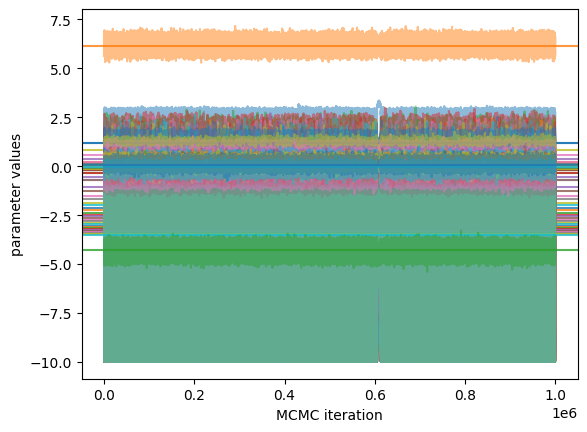

In [7]:
# trace plot
for i in range(ndim):
    plt.plot(samples[:, i], color=f'C{i}', alpha=0.5)
    plt.axhline(x_inj[i], color=f'C{i}', alpha=0.8)
plt.xlabel('MCMC iteration')
plt.ylabel('parameter values')
plt.show()

In [8]:
# # plot auto-correlations of paramters
# plt.bar(np.arange(ndim), np.array([integrated_time(samples[200_000:, i])[0] for i in range(ndim)]))
# plt.xlabel('parameter index')
# plt.ylabel('auto-correlation')
# plt.show()

Parameter $\log_{10} \rho_{2}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{30}$ in chain HMC is not constrained


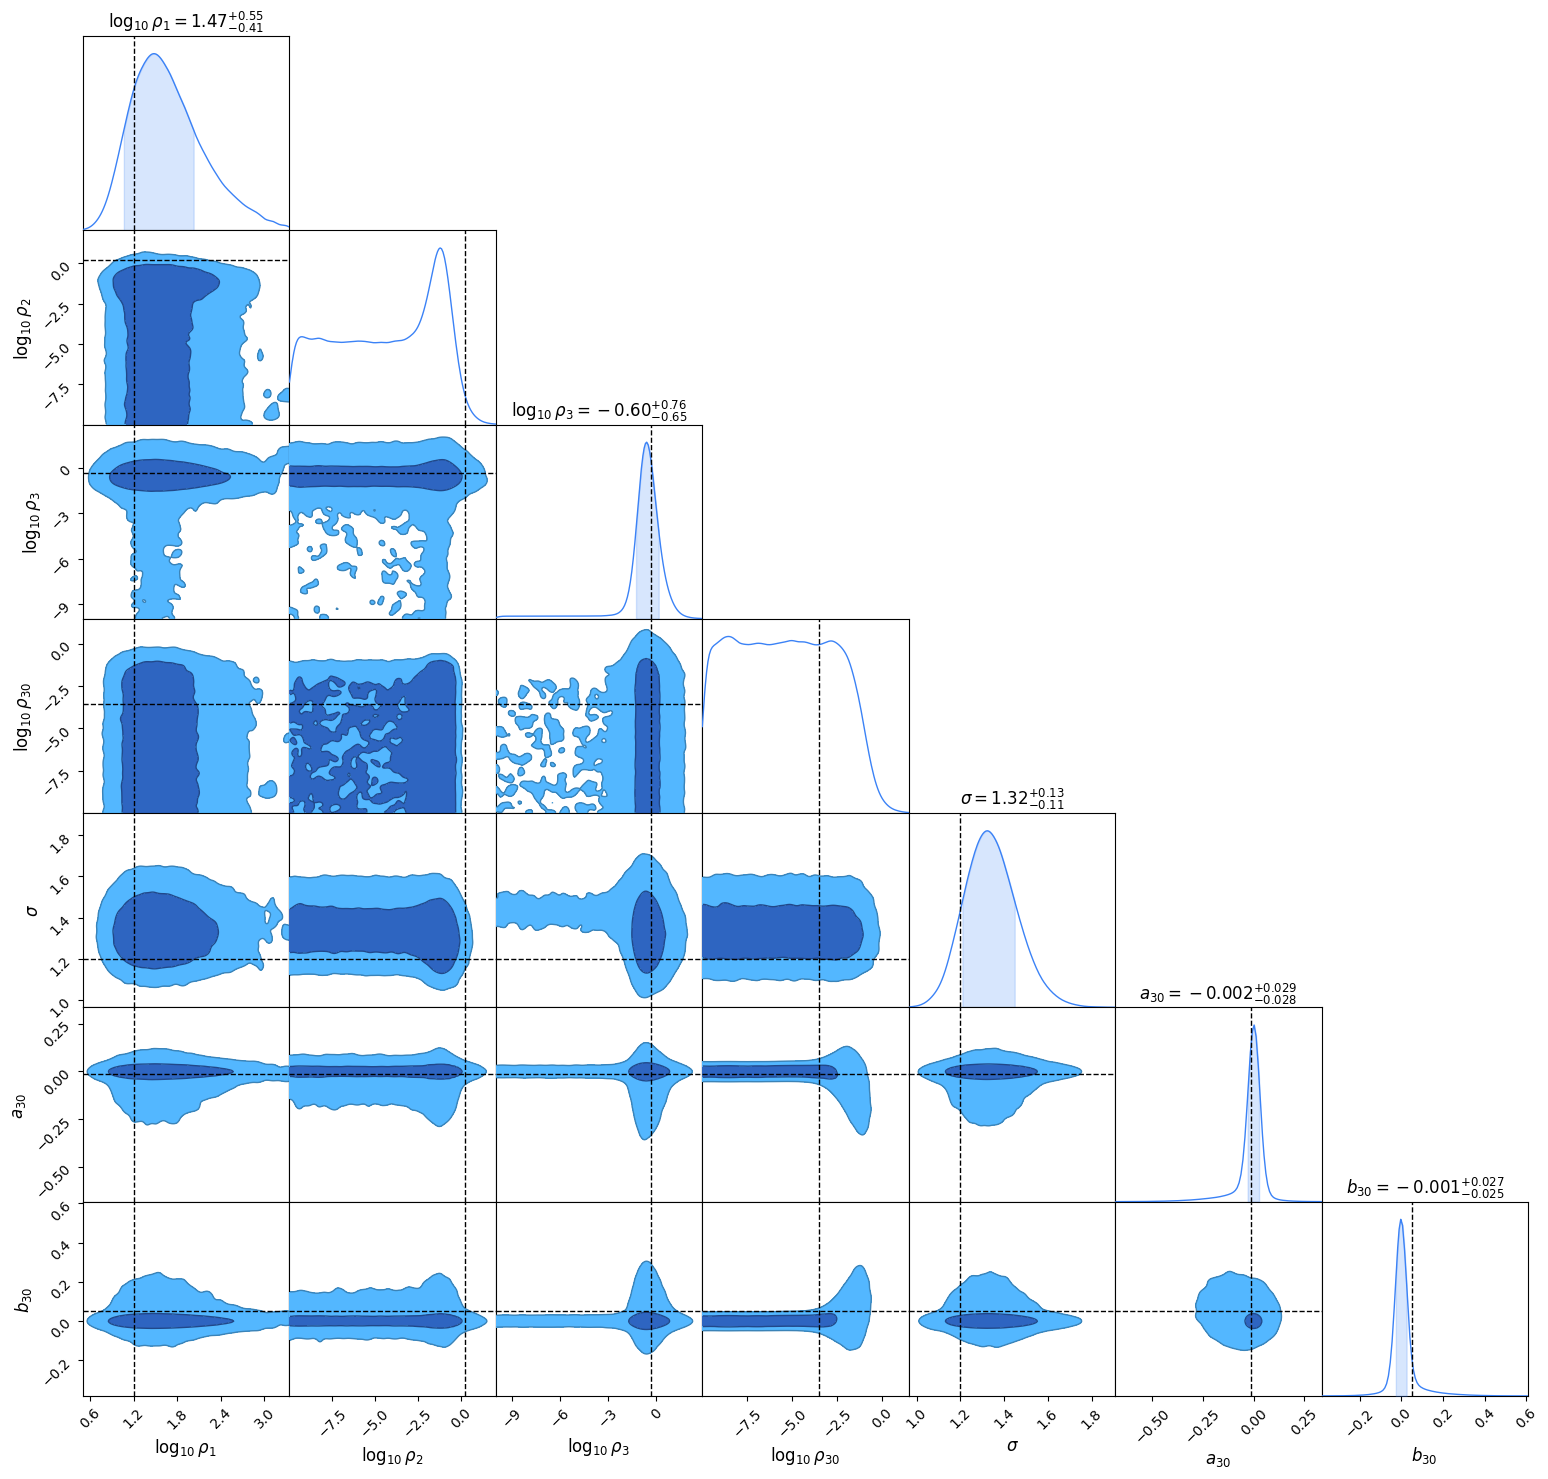

In [9]:
# posterior samples
ndxs = np.concatenate((np.r_[:3], np.r_[Nf - 1: Nf + 1], np.r_[-2:0]))
df = pd.DataFrame(samples[::5], columns=x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df.iloc[:, ndxs], name='HMC'))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels, x_inj)}))
fig = c.plotter.plot()

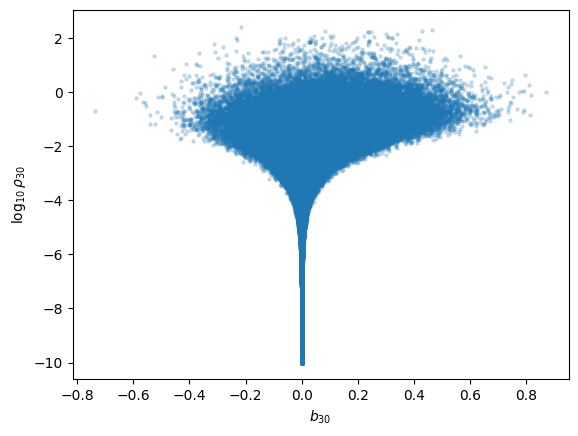

In [10]:
# visualize Neal's funnel
plt.scatter(samples[:, -1], samples[:, Nf - 1], color='C0', alpha=0.2, s=5)
plt.xlabel(x_labels[-1])
plt.ylabel(x_labels[Nf - 1])
plt.show()

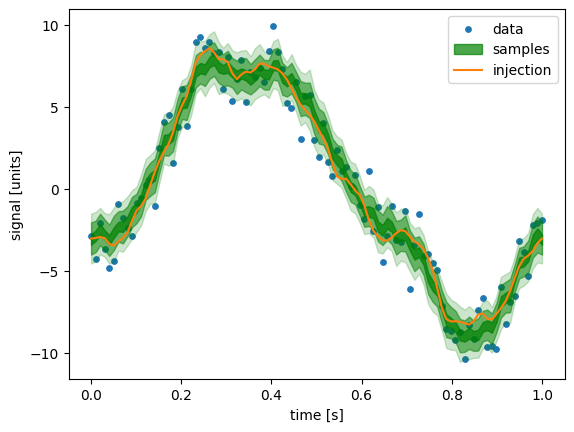

In [11]:
# signal recovery in time-domain (Bayesogram)
fair_draws_ndxs = jr.choice(jr.key(11), samples.shape[0], (1000,))
signals = np.array([F @ a for a in samples[fair_draws_ndxs, Nf + 1:]])

plt.scatter(times, data, color='C0', s=15, label='data')
plt.fill_between(times, np.percentile(signals, 0.5, axis=0), np.percentile(signals, 99.5, axis=0),
                 color='green', alpha=0.2)
plt.fill_between(times, np.percentile(signals, 5.0, axis=0), np.percentile(signals, 95., axis=0),
                 color='green', alpha=0.5)
plt.fill_between(times, np.percentile(signals, 30., axis=0), np.percentile(signals, 70., axis=0),
                 color='green', alpha=0.7, label='samples')
plt.plot(times, signal_inj, color='C1', label='injection')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend()
plt.show()

In [12]:
free_spectral_samples = samples[::2, :Nf]

free_spec_mean = jnp.mean(free_spectral_samples, axis=0)
L_cov = jnp.linalg.cholesky(jnp.cov(free_spectral_samples.T))
inv_L_cov = jnp.linalg.inv(L_cov)

@jit
def standardize(free_spec_samples):
    return jnp.einsum('ij,ni->nj', inv_L_cov, (free_spec_samples - free_spec_mean[None, :]))

@jit
def unstandardize(standard_samples):
    return free_spec_mean[None, :] + jnp.einsum('ij,ni->nj', L_cov, standard_samples)

standard_samples = standardize(free_spectral_samples)

100%|██████████| 200/200 [5:48:49<00:00, 104.65s/it, train=36.8, val=36.9]  


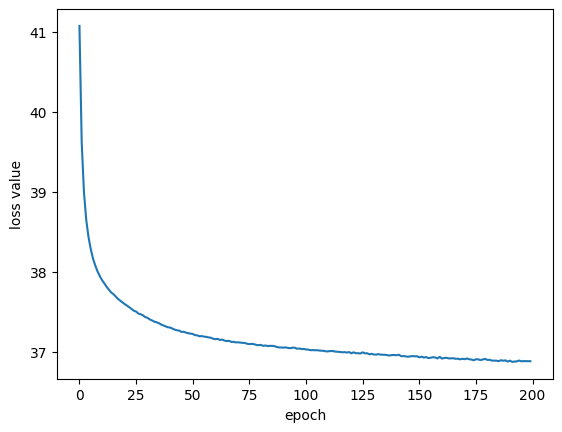

In [26]:
key, subkey = jr.split(jr.key(1))
flow = masked_autoregressive_flow(
    subkey,
    base_dist=Normal(jnp.zeros(standard_samples.shape[1]), scale=jnp.ones(standard_samples.shape[1])),
    transformer=RationalQuadraticSpline(knots=8, interval=4),
)

key, subkey = jr.split(key)
flow, losses = fit_to_data(subkey, flow, standard_samples, learning_rate=1e-4, batch_size=2048, max_patience=10, max_epochs=200)

plt.plot(losses['val'])
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

In [27]:
standard_flow_samples = flow.sample(subkey, (500_000,))
flow_samples = unstandardize(standard_flow_samples)

Parameter $\log_{10} \rho_{11}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{11}$ in chain normalizing flow is not constrained
Parameter $\log_{10} \rho_{12}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{12}$ in chain normalizing flow is not constrained
Parameter $\log_{10} \rho_{13}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{13}$ in chain normalizing flow is not constrained
Parameter $\log_{10} \rho_{14}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{15}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{16}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{17}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{17}$ in chain normalizing flow is not constrained
Parameter $\log_{10} \rho_{18}$ in chain HMC is not constrained
Parameter $\log_{10} \rho_{18}$ in chain normalizing flow is not constrained
Parameter $\log_{10} \rho_{19}$ in chain normalizing flow is not constrained
Parameter $\log_{10} \rho_

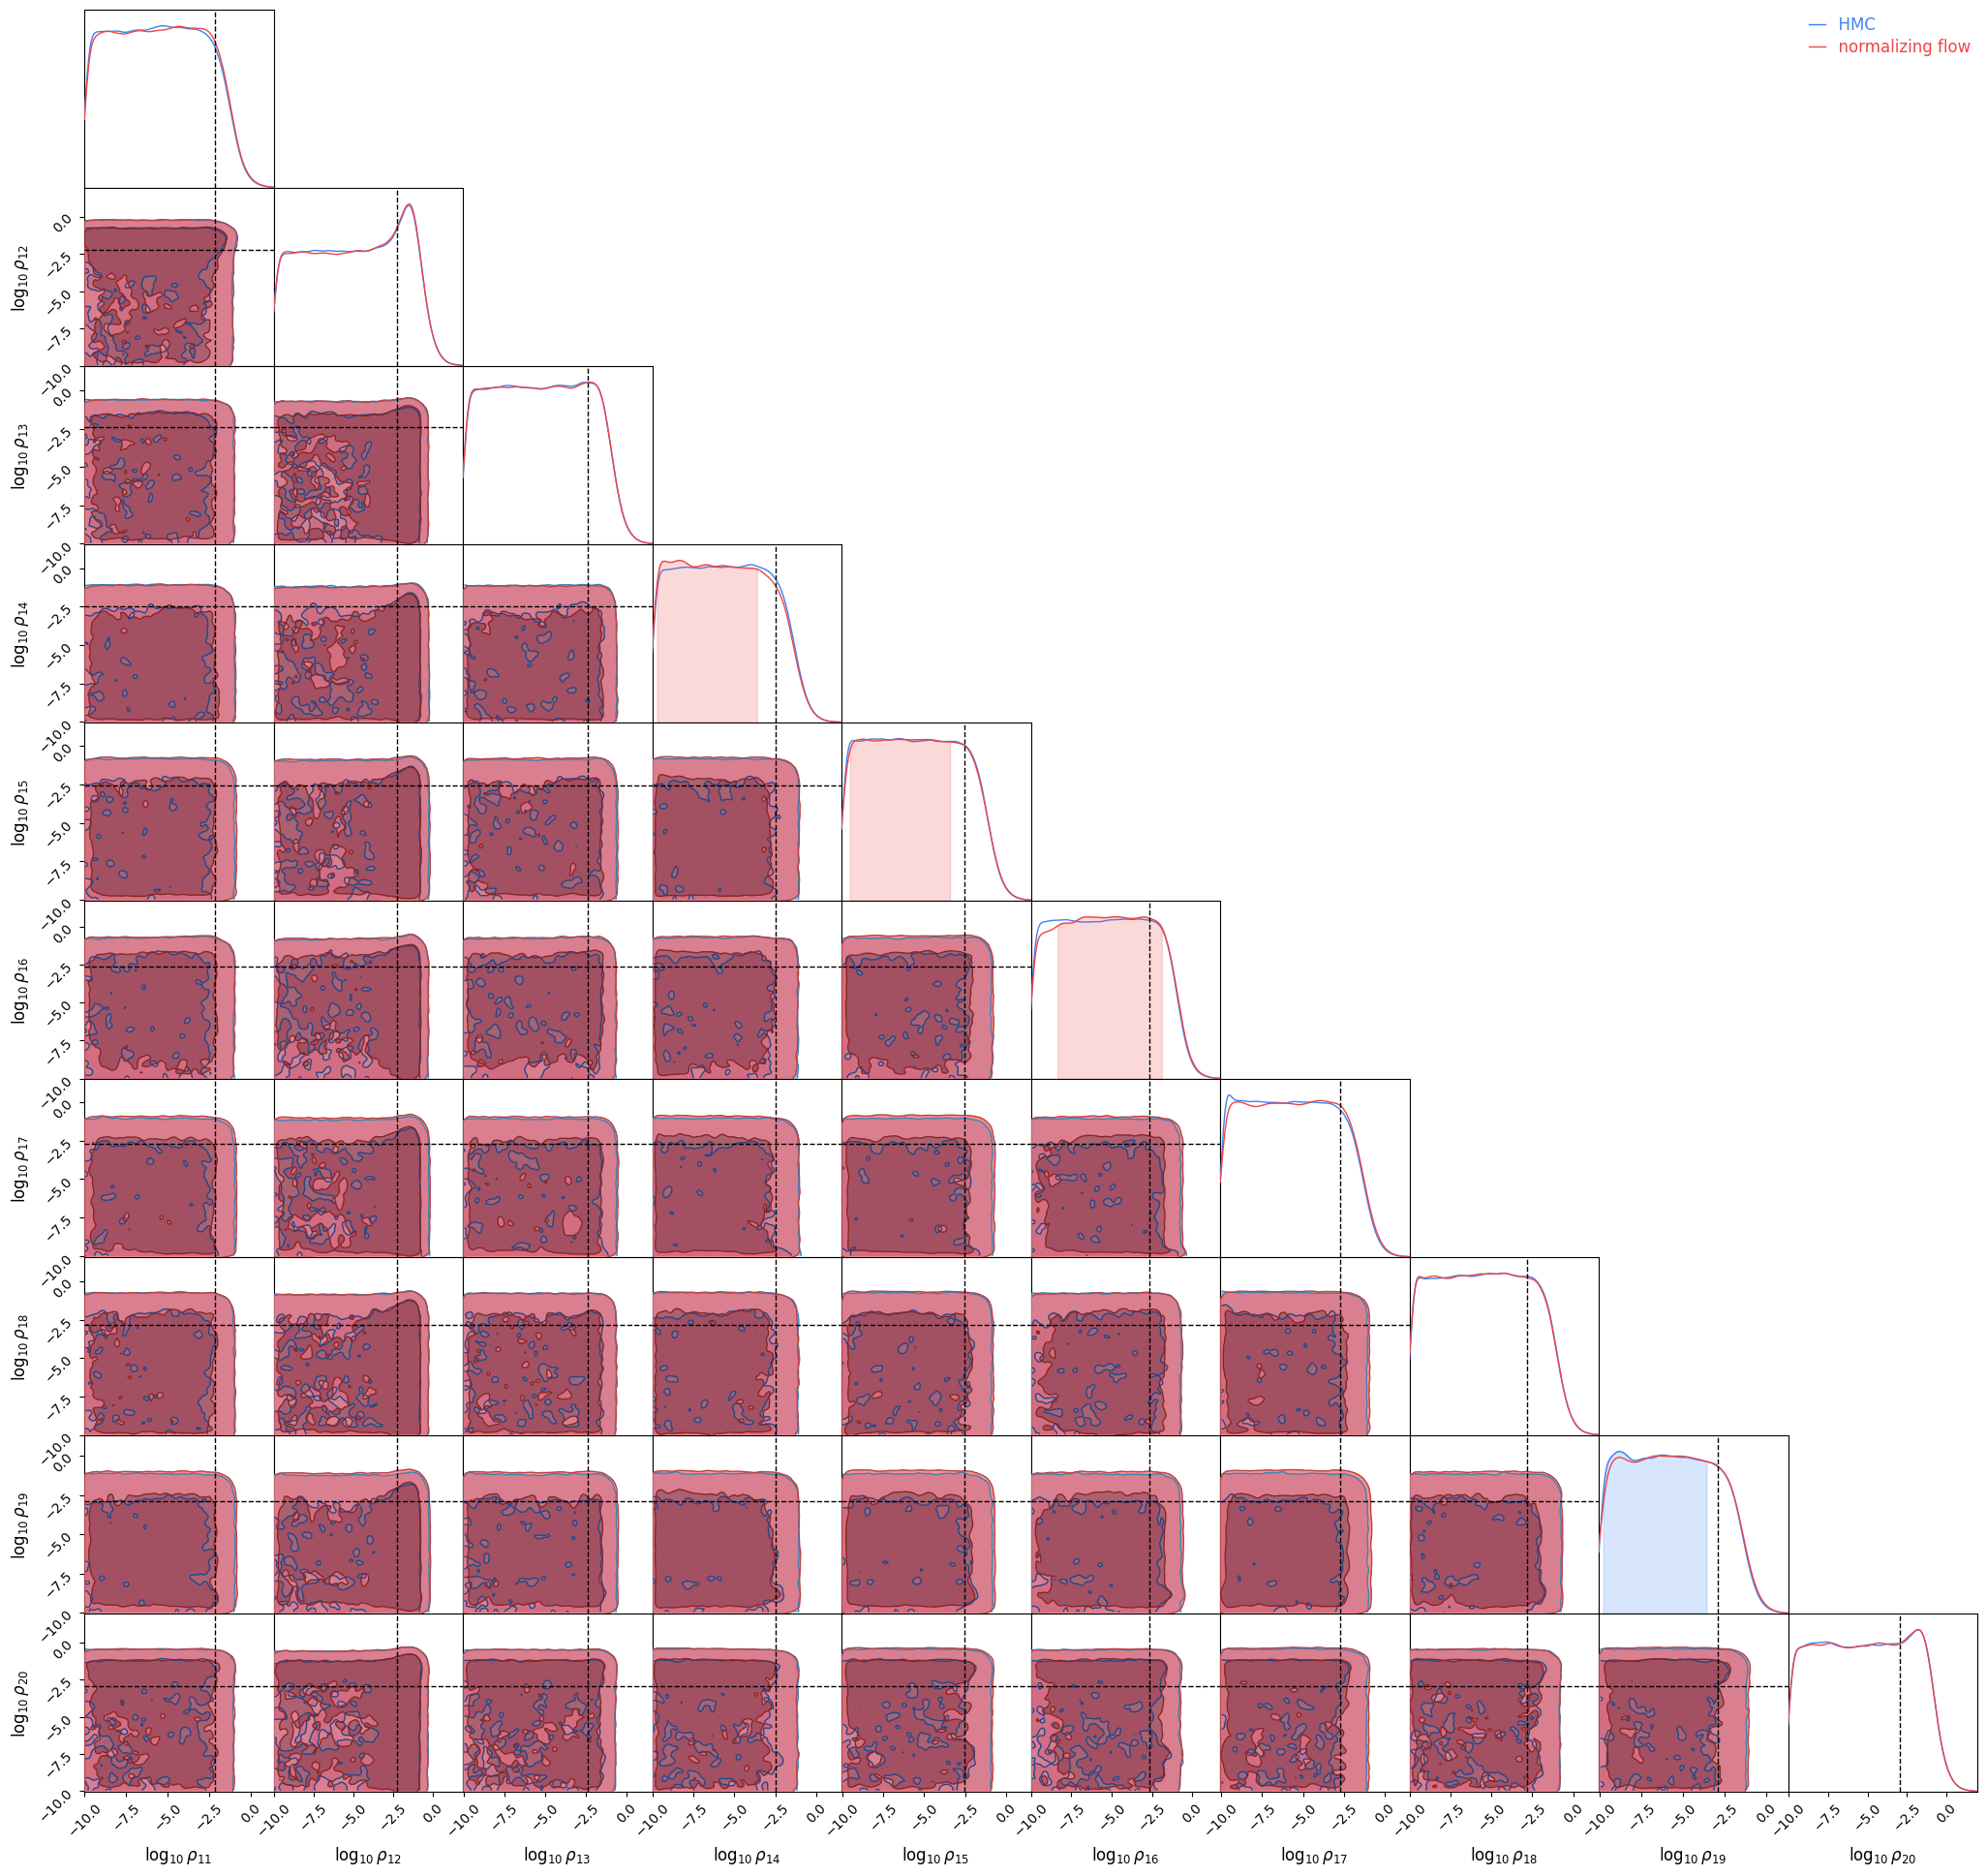

In [28]:
# plot original and flow samples
ndxs = np.r_[10:20]
df_hmc = pd.DataFrame(free_spectral_samples, columns=logrho_labels)
df_flow = pd.DataFrame(flow_samples, columns=logrho_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df_hmc.iloc[:, ndxs], name='HMC'))
c.add_chain(Chain(samples=df_flow.iloc[:, ndxs], name='normalizing flow', color='red'))
c.add_truth(Truth(location={name: val for name, val in zip(logrho_labels, logrho_inj)}))
fig = c.plotter.plot()

In [29]:
@jit
def second_stage_lnlike(x):
    log10rhos = jnp.log10(get_rho(*x))[::2]
    lnlike = flow.log_prob(standardize(log10rhos))
    return lnlike

In [30]:
# do HMC NUTS with Pyro
hyper_mins = jnp.array([0., 2.])
hyper_maxs = jnp.array([5., 7.])

def second_stage_sampling_model():
    hypers = numpyro.sample('hypers', dist.Uniform(hyper_mins, hyper_maxs))
    numpyro.factor('lnlike', second_stage_lnlike(hypers))

nuts_kernel = numpyro.infer.NUTS(model=second_stage_sampling_model,
                                   dense_mass=True)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                            num_warmup=int(5e3),
                            num_samples=int(1e5))
mcmc.run(jr.key(1))
hyper_samples_dict = mcmc.get_samples()
hyper_samples_free = hyper_samples_dict['hypers']

sample: 100%|██████████| 105000/105000 [07:43<00:00, 226.64it/s, 3 steps of size 6.13e-01. acc. prob=0.90] 


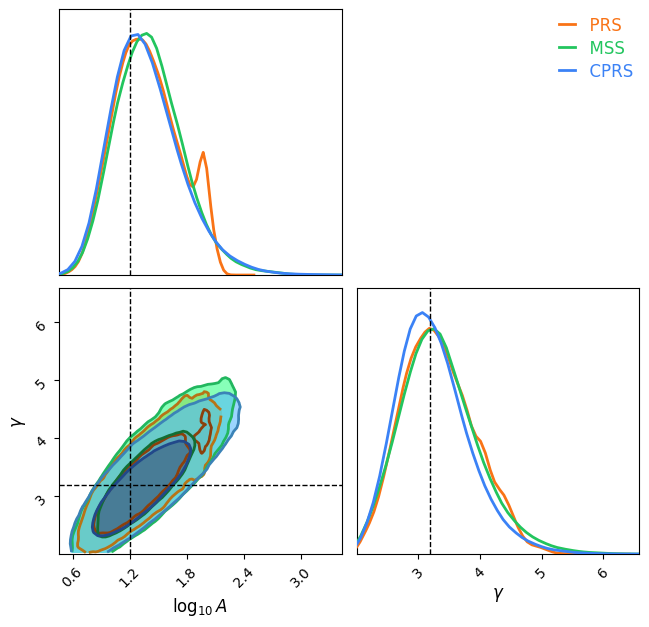

In [31]:
hyper_labels = [r'$\log_{{{10}}} A$', r'$\gamma$']
hypers_df = pd.DataFrame(hyper_samples_free, columns=hyper_labels)
# hypers_df = pd.DataFrame(hyper_samples_from_grid, columns=hyper_labels)
hyper_samples = pd.DataFrame(np.load('hypers.npy'), columns=hyper_labels)
standard_hyper_samples = pd.DataFrame(np.load('standard_hypers.npy'), columns=hyper_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=hyper_samples, name='PRS', smooth=1, linewidth=2, color='orange'))
c.add_chain(Chain(samples=hypers_df, name='MSS', smooth=1, linewidth=2, color='green'))
c.add_chain(Chain(samples=standard_hyper_samples, name='CPRS', smooth=1, linewidth=2, color='blue'))
c.add_truth(Truth(location={name: val for name, val in zip(hyper_labels, data_dict['hypers_inj'])}))
# c.set_plot_config(PlotConfig(watermark='Preliminary'))
c.set_override(ChainConfig(bar_shade=False))
fig = c.plotter.plot()

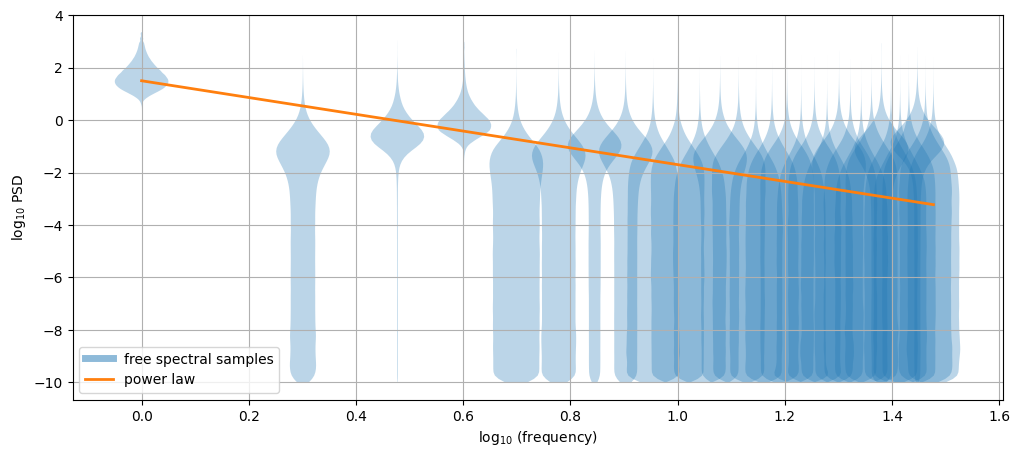

In [32]:
# violin plot
plt.figure(figsize=(12, 5))
plt.grid()
plt.violinplot(samples[:, :Nf], positions=jnp.log10(freqs), showextrema=False, widths=0.1)
# plt.scatter(jnp.log10(freqs), jnp.log10(a_inj[::2]**2. + a_inj[1::2]**2.), color='k', s=15, label='injection')
plt.plot([], [], color='C0', alpha=0.5, label='free spectral samples', lw=5)
# signals = np.array([np.log10(2. * get_rho(*hypers)[::2])
#                     for hypers in hyper_samples[jr.choice(jr.key(0), hyper_samples.shape[0], (1000,))]])
# plt.fill_between(jnp.log10(freqs), np.percentile(signals, 0.5, axis=0), np.percentile(signals, 99.5, axis=0),
#                  color='green', alpha=0.2)
# plt.fill_between(jnp.log10(freqs), np.percentile(signals, 5.0, axis=0), np.percentile(signals, 95., axis=0),
#                  color='green', alpha=0.5)
# plt.fill_between(jnp.log10(freqs), np.percentile(signals, 30., axis=0), np.percentile(signals, 70., axis=0),
#                  color='green', alpha=0.7, label='samples from normalizing flow')
plt.plot(jnp.log10(freqs), jnp.log10(2. * rho_inj[::2]), color='C1', label='power law', lw=2)
plt.xlabel(r'$\log_{{{10}}}\,$(frequency)')
plt.ylabel(r'$\log_{{{10}}}\,$PSD')
plt.legend(loc='lower left')
plt.show()